## Installing the necessary libraries

In [20]:
#!pip install karateclub

## Importing modules

In [39]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import random
from gensim.models import Word2Vec
from karateclub import Graph2Vec, NetLSD
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import seaborn as sns

In [22]:
df = pd.read_csv('LUT-48sample-ASTvalues7.csv')
df.head()

,CaseID,ast,AST7,ALT1,ALT7,TB1,INR1,TB7,INR7
0,LUT004,913,37,248,63,2.3,2.0,1.8,1.2
1,LUT005,2768,70,1725,280,1.2,1.4,1.2,1.1
2,LUT007,2996,52,962,140,2.5,1.8,1.6,1.1
3,LUT010,1529,57,964,177,1.5,2.5,1.2,1.2
4,LUT014,938,44,240,46,2.0,1.4,1.3,1.2


## Loading graph data

In [23]:
def readnetworks():
    directory_path = '/content'
    patientid=[]
    # Initialize an empty list to store the graphs
    graphs = []

    # Loop through each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.graphml.xml') and filename.split('.')[0] in str(df.CaseID):
            file_path = os.path.join(directory_path, filename)
            # Read the graphml file and append it to the list
            graph = nx.read_graphml(file_path)
            graphs.append(graph)
            patientid.append(filename.split('.')[0])
    return graphs,patientid



## Random walks

In [24]:

def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    for _ in range(walk_length - 1):
        current_node = walk[-1]
        neighbors = list(graph.neighbors(current_node))
        if neighbors:
            walk.append(random.choice(neighbors))
        else:
            break
    return walk

## Random weighted walks

In [25]:
def random_walk_weighted(G, start_node,walk_length):
        """Perform a weighted random walk starting from the start_node."""
        walk = [start_node]
        while len(walk) < walk_length:
            current_node = walk[-1]
            neighbors = list(G.neighbors(current_node))
            if len(neighbors) == 0:
                break
            # Get weights for neighbors
            # list(nx.get_node_attributes(G,'weight').values())
            weights = np.array([G.nodes[neighbor].get('weight', 1.0)  for neighbor in neighbors])
            probabilities = weights / weights.sum()
            # Choose the next node based on weights
            next_node = np.random.choice(neighbors, p=probabilities)
            walk.append(next_node)
        return walk

In [26]:
def generate_walks(graph, num_walks, walk_length, weighted = True):
    walks = []
    for _ in range(num_walks):
        for node in graph.nodes():
          if weighted:
            walks.append(random_walk_weighted(graph, node, walk_length))
          else:
            walks.append(random_walk(graph, node, walk_length))

    return walks

## Creating embeddings from walks

In [27]:
def generate_deepwalk_embeddings(graph, dimensions=128, walk_length=10, num_walks=20, weighted = True):
    # Generate random walks from the graph
    walks = generate_walks(graph, num_walks, walk_length, weighted)

    # Train a Word2Vec model on the random walks
    model = Word2Vec(walks, vector_size=dimensions, window=5, min_count=0, sg=1)

    # Create a vector for the entire graph by averaging node embeddings
    node_embeddings = np.array([model.wv[str(node)] for node in graph.nodes()])
    graph_embedding = np.mean(node_embeddings, axis=0)

    return graph_embedding

### DeepWalk Embedding

In [28]:
def learn_embeddingDW(GL,dimensions=128, walk_length=5, num_walks=20, weighted = True):
    embeddings=[]
    for idx, G in enumerate(GL):
      #spnetwork=df
      print(str(idx))
      embeddings.append(generate_deepwalk_embeddings(G,dimensions=128, walk_length=5, num_walks=20, weighted = weighted))

    np.save('embeddings'+str(dimensions)+'.npy',embeddings)
    # Saving the array in a text file

    return embeddings

### Graph2Vector Embedding

In [29]:
def learn_embeddingGV(graphs):
    model = Graph2Vec(dimensions=128, wl_iterations=2)  # dimensions = embedding size, wl_iterations = Weisfeiler-Lehman steps

    # Step 3: Fit the model on the list of graphs
    model.fit(graphs)

    # Step 4: Extract embeddings
    embeddings = model.get_embedding()
    return embeddings

In [30]:
def relabel_graphs(graphs):
    relabeled_graphs = []
    for G in graphs:
        # This relabels the nodes of G with consecutive integers starting from 0
        G_relabeled = nx.convert_node_labels_to_integers(G, first_label=0)
        relabeled_graphs.append(G_relabeled)
    return relabeled_graphs



In [31]:
def read_embedding(dimensions):
    embeddings = np.load('embeddings'+str(dimensions)+'.npy')
    return embeddings


In [32]:
from karateclub import FGSD

GL,patientid=readnetworks()
dimensions=128
#this learn embedding used the graph embeding codes above. You need to find other attributed graph embedding models and try those here
# Assuming GL is your list of graphs
GL_relabeled = relabel_graphs(GL)
embeddings_GV = learn_embeddingGV(GL_relabeled)




In [33]:
print("Numpy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)

Numpy version: 1.22.4
Scikit-learn version: 1.5.2


In [34]:
embeddings_DW_weighted = learn_embeddingDW(GL,dimensions=128, walk_length=5, num_walks=20, weighted=True)
embeddings_DW_weighted = read_embedding(dimensions)
embeddings_DW_unweighted = learn_embeddingDW(GL,dimensions=128, walk_length=5, num_walks=20, weighted=False)
embeddings_DW_unweighted = read_embedding(dimensions)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [45]:
def plot_metric_groups(ast, method_name=""):
    """
    Plots three groups of metrics in separate bar plots.

    Groups:
    1. TB1, INR1, TB7, INR7
    2. AST, ALT1
    3. AST7, ALT7

    Parameters:
    - ast (pd.DataFrame): The AST dataframe with 'Cluster' column.
    - method_name (str): Name of the embedding method for display purposes.
    """
    # Define the metric groups
    groups = {
        "TB and INR Metrics": ['TB1', 'INR1', 'TB7', 'INR7'],
        "AST and ALT1 Metrics": ['ast', 'ALT1'],
        "AST7 and ALT7 Metrics": ['AST7', 'ALT7']
    }

    # Set up the matplotlib figure
    plt.figure(figsize=(18, 5))

    for i, (group_name, metrics) in enumerate(groups.items(), 1):
        plt.subplot(1, 3, i)

        # Calculate the average values per cluster for the current group
        averages = ast.groupby('Cluster')[metrics].mean().reset_index()

        # Melt the dataframe for seaborn
        averages_melted = averages.melt(id_vars='Cluster', var_name='Metric', value_name='Average Value')

        # Create a bar plot
        sns.barplot(data=averages_melted, x='Cluster', y='Average Value', hue='Metric')

        # Set titles and labels
        plt.title(f'Average {group_name} per Cluster ({method_name})')
        plt.xlabel('Cluster')
        plt.ylabel('Average Value')
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [46]:

# Read the AST data
ast = pd.read_csv('LUT-48sample-ASTvalues7.csv')



def cluster_graphs(embeddings, ast, num_clusters=6, method_name=""):
    """
    Clusters graph embeddings, adds cluster labels to the AST dataframe,
    and displays the results in a well-formatted manner.

    Parameters:
    - embeddings (np.ndarray): The graph embeddings.
    - ast (pd.DataFrame): The AST dataframe.
    - num_clusters (int): Number of clusters for K-Means.
    - method_name (str): Name of the embedding method for display purposes.
    """
    # Compute the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings)

    # Initialize and fit K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(similarity_matrix)

    # Retrieve cluster labels and add to AST dataframe
    cluster_labels = kmeans.labels_
    ast['Cluster'] = cluster_labels

    # Display Cluster Assignments
    print(f"\n=== Clustering Results: {method_name} ===")
    print("Cluster assignments added to AST DataFrame:")
    print(tabulate(ast.head(), headers='keys', tablefmt='fancy_grid', showindex=False))

    # Calculate mean for numeric columns
    numeric_cols = ast.select_dtypes(include=[np.number]).columns.tolist()
    if 'Cluster' in numeric_cols:
        numeric_cols.remove('Cluster')  # Exclude 'Cluster' from averaging

    averages = ast.groupby('Cluster')[numeric_cols].mean()

    # Display the averages in a formatted table
    print(f"\nAverage AST Values per Cluster for {method_name}:")
    print(tabulate(averages, headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))

    # Optional: Compute Silhouette Score
    silhouette_avg = silhouette_score(similarity_matrix, cluster_labels)
    print(f"\nSilhouette Score for {method_name}: {silhouette_avg:.4f}")

    # Visualization: Bar plots for the specified groups
    plot_metric_groups(ast, method_name)


=== Clustering Results: Graph2Vec Embeddings ===

=== Clustering Results:  ===
Cluster assignments added to AST DataFrame:
╒══════════╤═══════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤═══════════╕
│ CaseID   │   ast │   AST7 │   ALT1 │   ALT7 │   TB1 │   INR1 │   TB7 │   INR7 │   Cluster │
╞══════════╪═══════╪════════╪════════╪════════╪═══════╪════════╪═══════╪════════╪═══════════╡
│ LUT004   │   913 │     37 │    248 │     63 │   2.3 │    2   │   1.8 │    1.2 │         0 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT005   │  2768 │     70 │   1725 │    280 │   1.2 │    1.4 │   1.2 │    1.1 │         2 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT007   │  2996 │     52 │    962 │    140 │   2.5 │    1.8 │   1.6 │    1.1 │         0 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT010   │  1529 │     57 │  

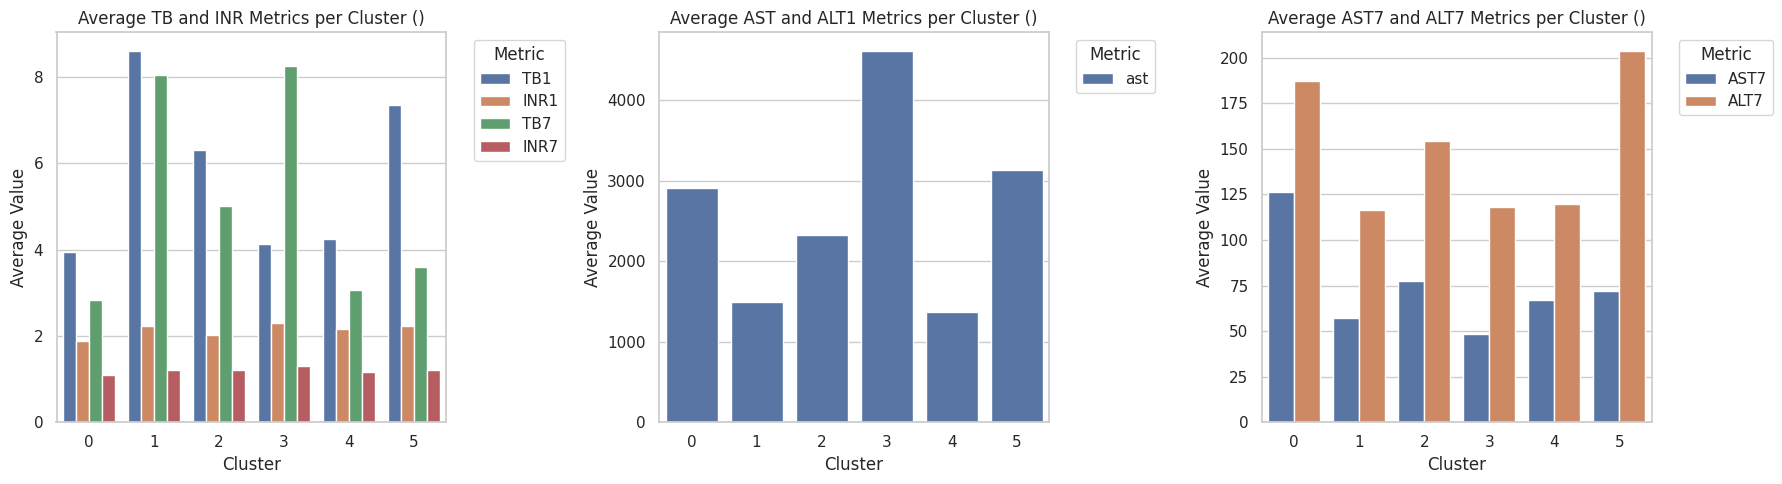

----------------------------------------------------------------------------------------------------
=== Clustering Results: DeepWalk Weighted Embeddings ===

=== Clustering Results:  ===
Cluster assignments added to AST DataFrame:
╒══════════╤═══════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤═══════════╕
│ CaseID   │   ast │   AST7 │   ALT1 │   ALT7 │   TB1 │   INR1 │   TB7 │   INR7 │   Cluster │
╞══════════╪═══════╪════════╪════════╪════════╪═══════╪════════╪═══════╪════════╪═══════════╡
│ LUT004   │   913 │     37 │    248 │     63 │   2.3 │    2   │   1.8 │    1.2 │         4 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT005   │  2768 │     70 │   1725 │    280 │   1.2 │    1.4 │   1.2 │    1.1 │         4 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT007   │  2996 │     52 │    962 │    140 │   2.5 │    1.8 │   1.6 │    1.1 │         5 │
├──────────┼────

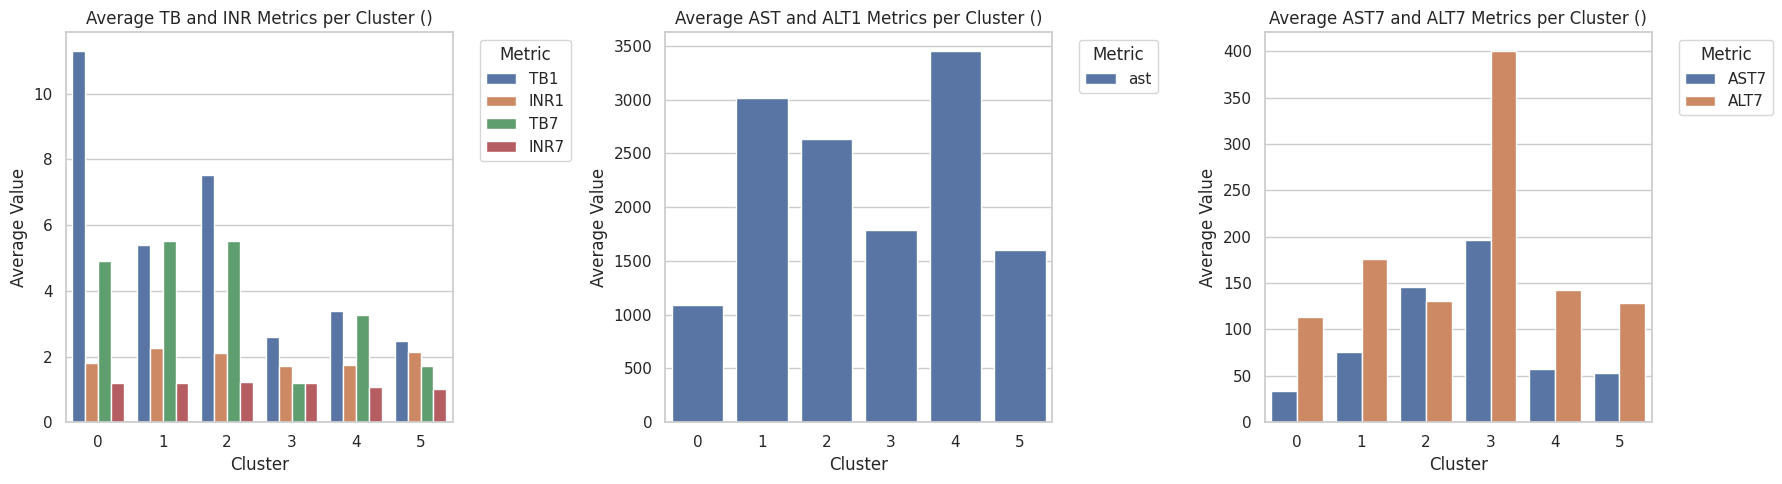

----------------------------------------------------------------------------------------------------
=== Clustering Results: DeepWalk Unweighted Embeddings ===

=== Clustering Results:  ===
Cluster assignments added to AST DataFrame:
╒══════════╤═══════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤═══════════╕
│ CaseID   │   ast │   AST7 │   ALT1 │   ALT7 │   TB1 │   INR1 │   TB7 │   INR7 │   Cluster │
╞══════════╪═══════╪════════╪════════╪════════╪═══════╪════════╪═══════╪════════╪═══════════╡
│ LUT004   │   913 │     37 │    248 │     63 │   2.3 │    2   │   1.8 │    1.2 │         4 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT005   │  2768 │     70 │   1725 │    280 │   1.2 │    1.4 │   1.2 │    1.1 │         4 │
├──────────┼───────┼────────┼────────┼────────┼───────┼────────┼───────┼────────┼───────────┤
│ LUT007   │  2996 │     52 │    962 │    140 │   2.5 │    1.8 │   1.6 │    1.1 │         3 │
├──────────┼──

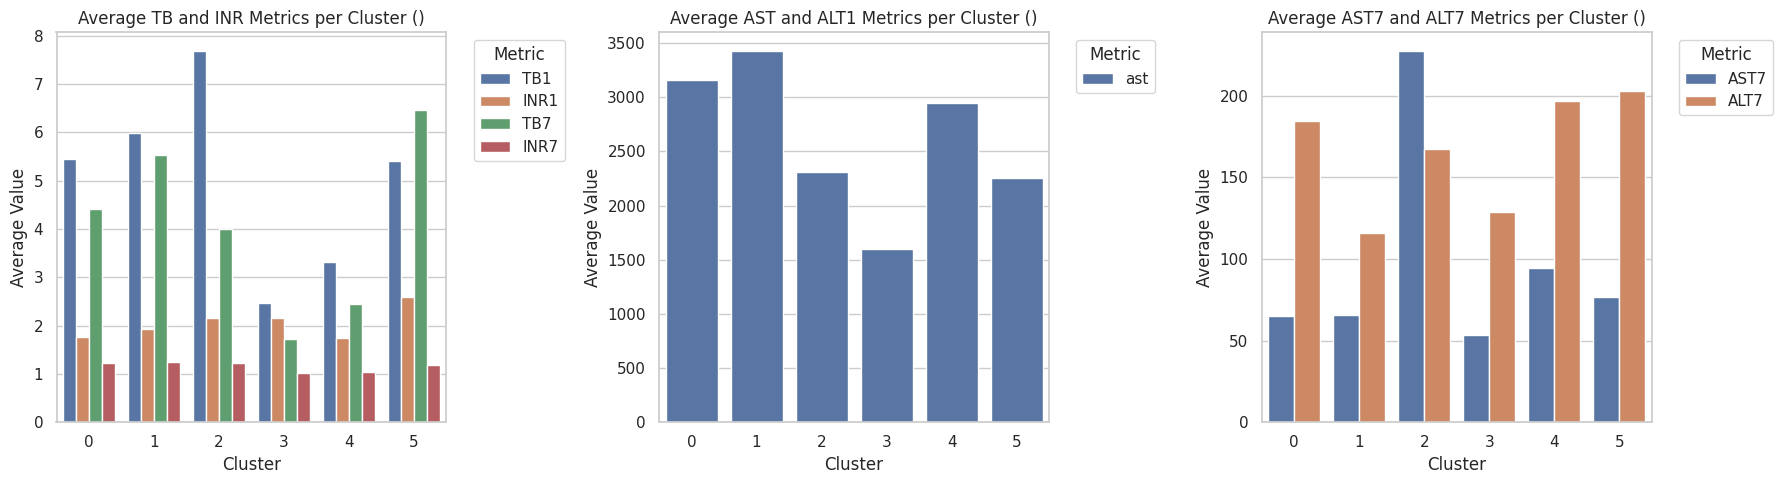

----------------------------------------------------------------------------------------------------


In [47]:
# Cluster the graphs using different embedding methods and display results

print("=== Clustering Results: Graph2Vec Embeddings ===")
cluster_graphs(embeddings_GV, ast)
print('-' * 100)

print("=== Clustering Results: DeepWalk Weighted Embeddings ===")
cluster_graphs(embeddings_DW_weighted, ast)
print('-' * 100)

print("=== Clustering Results: DeepWalk Unweighted Embeddings ===")
cluster_graphs(embeddings_DW_unweighted, ast)
print('-' * 100)



In [48]:
ast.Cluster.value_counts()

,Cluster
1,13
4,11
5,8
2,6
0,5
3,4
